# Isolated Sign Language Recognition : dive in 

This notebook is the continuation of my previous notebook [here](https://www.kaggle.com/code/dorianmb/isolated-sign-language-recognition-quick-start?scriptVersionId=121909882)



# Credits

Notebook that help me : 
- [NGHI HUYNH's notebook](https://www.kaggle.com/code/nghihuynh/gislr-eda-feature-processing)
- [ROBERT HATCH' notbook](https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders/notebook#PREPROCESSING)
- [JVTHUNDER's notebook](https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language)


# As newbie on kaggle, I am open to any suggestion for improvement.

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import os
import random
import json

## Install nb_black for autoformatting
!pip install nb_black --quiet
%load_ext lab_black

In [2]:
print("tensorflow version : ", tf.__version__)

tensorflow version :  2.11.0


# Set-up & Reproducible

In [3]:
# Constante
SEED = 42
ROWS_PER_FRAME = 543
data_dir = "/kaggle/input/asl-signs"
landmark_fimes_dir = "/kaggle/input/asl-signs/train_landmark_files"

In [4]:
def seed_it_all(seed=SEED):
    os.environ["pythonhashseed"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_it_all()  # Reproducible

In [5]:
def load_relevant_data_subset(pq_path):
    data_columns = ["x", "y", "z"]
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [6]:
def read_json(path):
    with open(path, "r") as file:
        json_data = json.load(file)
    return json_data

# Load data

In [7]:
path_train_df = pd.read_csv(data_dir + "/train.csv")
path_train_df["path"] = data_dir + "/" + path_train_df["path"]
display(path_train_df.head(2)), len(path_train_df)

,path,participant_id,sequence_id,sign
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait


(None, 94477)

In [8]:
s2p_map = read_json(os.path.join(data_dir, "sign_to_prediction_index_map.json"))
p2s_map = {v: k for k, v in s2p_map.items()}

encoder = lambda x: s2p_map.get(x)
decoder = lambda x: p2s_map.get(x)

path_train_df["label"] = path_train_df["sign"].map(encoder)

display(path_train_df.head(2)), path_train_df.shape

,path,participant_id,sequence_id,sign,label
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,25
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,232


(None, (94477, 5))

In [9]:
sample = pd.read_parquet(path_train_df.path[0])
sample.head()

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152


**need to select usefull Landmark index**

# Quick EDA and Preprocessing

## Distribution of number of frame per sequence over the dataset

In [10]:
# let's check the distribution of n_frame over the dataset
distribution_lenght = int(len(path_train_df) / 100)
frames = np.zeros(distribution_lenght)
for index, row in tqdm(path_train_df.iterrows(), total=distribution_lenght):
    if index > distribution_lenght - 1:
        break
    x = load_relevant_data_subset(row.path)
    frames[index] = x.shape[0]

  0%|          | 0/944 [00:00<?, ?it/s]

In [11]:
print("----------------------------------------------------")
print("minimum frames in sequence : ", frames.min())
print("maximum frames in sequence : ", frames.max())
print(f"mean of frames in the first {distribution_lenght} sequences", frames.mean())
print(f"median of frames in the first {distribution_lenght} sequences", np.median(frames))
print("----------------------------------------------------")

----------------------------------------------------
minimum frames in sequence :  3.0
maximum frames in sequence :  311.0
mean of frames in the first 944 sequences 38.4396186440678
median of frames in the first 944 sequences 23.0
----------------------------------------------------


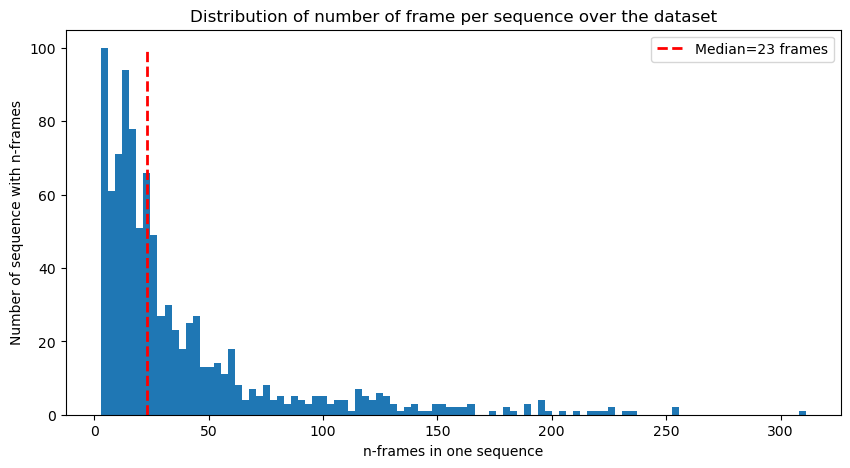

In [12]:
plt.figure(figsize=(10, 5))
hist = plt.hist(frames, bins=100)

median = np.median(frames)
plt.plot(
    [median, median],
    [0, hist[0].max()],
    "--",
    c="red",
    linewidth=2,
    label=f"Median={median:.0f} frames",
)

plt.title("Distribution of number of frame per sequence over the dataset")
plt.xlabel("n-frames in one sequence")
plt.ylabel("Number of sequence with n-frames")

plt.legend()
plt.show()

In [13]:
int(np.percentile(frames, 25))

13

## Herlper function

In [14]:
def tf_nan_mean(x, axis=0):
    x_zero_insted_of_nan = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x_zero_for_nan_else_one = tf.where(
        tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)
    )
    x_out = tf.reduce_sum(x_zero_insted_of_nan, axis=axis) / tf.reduce_sum(
        x_zero_for_nan_else_one, axis=axis
    )
    return tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))


def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

## Configuration

In [15]:
DROP_Z = False

# Drop most of the face landmarks to reduce the dimensionality
LANDMARK = [0, 9, 11, 13, 14, 17, 117, 118, 119, 199, 346, 347, 348] + list(
    range(468, 543)
)

LENGHT_LANDMARK = len(LANDMARK)
N_DATA = len(["x", "y"]) if DROP_Z else len(["x", "y", "z"])
FIXED_FRAME = int(np.median(frames))
SHAPE = [FIXED_FRAME, LENGHT_LANDMARK, N_DATA]

print("----------------------------------------------------")
print("Drop Z in data column :", DROP_Z, end="\n\n")
print("Fixed Frame (shape[0]) =", FIXED_FRAME, end="\n\n")
print("Shape =", SHAPE, end="\n\n")
print("----------------------------------------------------")

----------------------------------------------------
Drop Z in data column : False

Fixed Frame (shape[0]) = 23

Shape = [23, 88, 3]

----------------------------------------------------


## Feature Generator

In [16]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        if x.shape[0] is None :
            n_frames = FIXED_FRAME
        else :
            n_frames = x.shape[0]

        # Drop "z" column
        if DROP_Z:
            x = x[:, :, 0:2]

        # NaN values become 0
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

        # Landmarks reduction
        # Select only the usefull landmark
        x = tf.gather(
            x,
            indices=LANDMARK,
            axis=1,
        )
        
        if FIXED_FRAME > n_frames:
            outputs = tf.image.resize(x, size=[SHAPE[0], SHAPE[1]], method="bilinear")
        else:
            outputs = tf.image.resize(x, size=[SHAPE[0], SHAPE[1]], method="nearest")

        return outputs


feature_converter = FeatureGen()

In [17]:
# Some test
sample = load_relevant_data_subset(path_train_df.path[1])
prepocesse_sample = feature_converter(sample)
prepocesse_sample.shape, sample.shape

(TensorShape([23, 88, 3]), (11, 543, 3))

## Making data

In [18]:
TOTAL_DATA_LENGHT = len(path_train_df)
DATA_LENGHT_EXPERIMENT = int(len(path_train_df) / 100)

print("----------------------------------------------------")
print("Lenght of data for modeling :", DATA_LENGHT_EXPERIMENT)
print(f"Percentage of total data {DATA_LENGHT_EXPERIMENT/TOTAL_DATA_LENGHT*100:.1f}%")
print("----------------------------------------------------")

----------------------------------------------------
Lenght of data for modeling : 944
Percentage of total data 1.0%
----------------------------------------------------


In [19]:
def convert_row(row):
    x = load_relevant_data_subset(row.path)
    x = feature_converter(x)
    return x, row.label


def convert_and_save_data(data_lenght=DATA_LENGHT_EXPERIMENT):
    np_features = np.zeros([data_lenght] + SHAPE)
    np_labels = np.zeros(data_lenght)
    
    print("----------------------------------------------------")
    print(f"Total data to processe : {data_lenght}")
    print(f"Percentage of total data {data_lenght/TOTAL_DATA_LENGHT*100:.2f}%")
    print("----------------------------------------------------")
    
    for index, row in tqdm(path_train_df.iterrows(), total=data_lenght):
        if index > data_lenght - 1:
            break

        if index % (DATA_LENGHT_EXPERIMENT // 10) == 0:
            print(f"Data processed {index/data_lenght*100:.1f}%")

        data = load_relevant_data_subset(row.path)
        feature, label = convert_row(row)
        np_features[index] = feature
        np_labels[index] = label

    np.save("features.npy", np_features)
    np.save("labels.npy", np_labels)

In [20]:
try:
    features = np.load("/kaggle/working/features.npy")
    labels = np.load("/kaggle/working/labels.npy")
    print("Data Load successfully")
except:
    print("Loading DATA has fail... \nCreating DataSet")
    convert_and_save_data(DATA_LENGHT_EXPERIMENT)

    features = np.load("features.npy")
    labels = np.load("labels.npy")

Loading DATA has fail... 
Creating DataSet
----------------------------------------------------
Total data to processe : 944
Percentage of total data 1.00%
----------------------------------------------------


  0%|          | 0/944 [00:00<?, ?it/s]

Data processed 0.0%
Data processed 10.0%
Data processed 19.9%
Data processed 29.9%
Data processed 39.8%
Data processed 49.8%
Data processed 59.7%
Data processed 69.7%
Data processed 79.7%
Data processed 89.6%
Data processed 99.6%


In [21]:
test_size=0.2
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=test_size, random_state=SEED
)

del features,labels # delete, usefull with full data otherwise it fail (memorry issues)

buffer_size = int(DATA_LENGHT_EXPERIMENT / 10)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(128, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(128, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("----------------------------------------------------")
print("X_train shape = ", X_train.shape)
print("X_val shape = ", X_val.shape)
print("y_train shape = ", y_train.shape)
print("y_val shape = ", y_val.shape)
print("----------------------------------------------------")

----------------------------------------------------
X_train shape =  (755, 23, 88, 3)
X_val shape =  (189, 23, 88, 3)
y_train shape =  (755,)
y_val shape =  (189,)
----------------------------------------------------


In [22]:
# Quick test -> after training
quick_test_idx = np.random.randint(0, len(y_val), size=(10,))  # See after training
quick_test_X = np.take(X_val, quick_test_idx, axis=0)
quick_test_y = np.take(y_val, quick_test_idx, axis=0)
del X_train, X_val, y_train, y_val

# Modeling

In [23]:
class DenseBlock(layers.Layer):
    def __init__(self, units, drop):
        super().__init__()
        self.dense = layers.Dense(units)
        self.norm = layers.LayerNormalization()
        self.relu = layers.Activation("relu")
        self.drop = layers.Dropout(drop)
        
    def call(self, x):
        x = self.dense(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

class ClassifierLSTM(layers.Layer):
    def __init__(self, lstm_units, drop):
        super().__init__()
        self.dropout = layers.Dropout(drop)
        self.pool2d = layers.AveragePooling2D(pool_size=(4, 1)) # Keep the same number of landmark
        self.reshape = layers.Reshape((-1, 64))
        self.lstm = layers.LSTM(units=lstm_units, return_sequences=True)
        self.pool1d = layers.AveragePooling1D(pool_size=4)
        self.flat = layers.Flatten()
        self.outputs = layers.Dense(250, activation="softmax", name="predictions")
    
    def call(self, x): # (None, 23, 88, 64)
        x = self.pool2d(x) # (None, 5, 88, 64)
        x = self.reshape(x) # (None, 2024, 64)
        x = self.lstm(x) # (None, 2024, 250)
        x = self.dropout(x)
        x = self.pool1d(x) # (None, 506, 250)
        x = self.flat(x) # (None, 126_500)
        outputs = self.outputs(x) # (None, 126 _00)
        return outputs


class ClassifierConvLSTM1D(layers.Layer):
    def __init__(self, lstm_units, drop):
        super().__init__()
        self.pool2d = layers.AveragePooling2D(pool_size=(6, 1)) # Keep the same number of landmark
        self.conv_lstm1D = layers.ConvLSTM1D(filters=lstm_units, kernel_size=1) # RNN capable of learning long-term dependencies
        self.dropout = layers.Dropout(drop)
        self.flat = layers.Flatten()
        self.outputs = layers.Dense(250, activation="softmax", name="predictions")
    
    def call(self, x): # (None, 23, 88, 64)
        x = self.pool2d(x) # (None, 5, 88, 64)
        x = self.conv_lstm1D(x) # (None, 88, 250)
        x = self.dropout(x)
        x = self.flat(x)
        outputs = self.outputs(x)
        return outputs

In [24]:
def get_model(
    encoder_units=[128, 64],
    drop=0.5,
    lstm_units=250,
    shape=SHAPE,
    learning_rate=0.001,
):
    inputs = layers.Input(shape=shape)
    x = inputs

    for units in encoder_units:
        x = DenseBlock(units, drop)(x)

    outputs = ClassifierConvLSTM1D(lstm_units, drop)(x)
    # ClassifierConvLSTM1D
    # ClassifierLSTM

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    return model

In [25]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=10, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=3
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "./ASL_model",
            save_best_only=True,
            restore_best_weights=True,
            monitor="val_accuracy",
            mode="max",
            verbose=False,
        ),
    ]


cb_list = get_callbacks()

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23, 88, 3)]       0         
                                                                 
 dense_block (DenseBlock)    (None, 23, 88, 128)       768       
                                                                 
 dense_block_1 (DenseBlock)  (None, 23, 88, 64)        8384      
                                                                 
 classifier_conv_lstm1d (Cla  (None, 250)              5815250   
 ssifierConvLSTM1D)                                              
                                                                 
Total params: 5,824,402
Trainable params: 5,824,402
Non-trainable params: 0
_________________________________________________________________


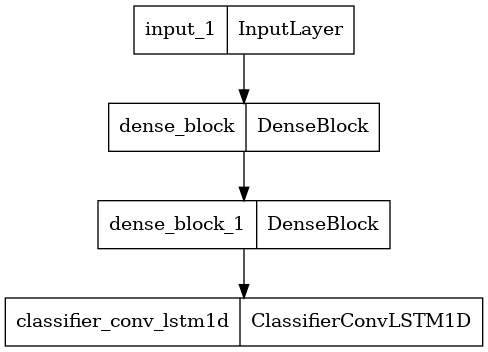

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(model, expand_nested=False)

In [27]:
print("----------------------------------------------------")
print("Guessing: ", 1 / 250)
print("Data per Class:", DATA_LENGHT_EXPERIMENT*(1-test_size) / 250)
print("----------------------------------------------------")

----------------------------------------------------
Guessing:  0.004
Data per Class: 3.0208000000000004
----------------------------------------------------


## Fit

In [28]:
%%time
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=1,
    callbacks=cb_list
)

2023-04-01 13:44:31.955041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/dense_block_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5/5 [==============================] - 16s 2s/step - loss: 5.7862 - accuracy: 0.0063 - val_loss: 5.6257 - val_accuracy: 0.0156 - lr: 0.0010
CPU times: user 10.4 s, sys: 1.12 s, total: 11.6 s
Wall time: 23.7 s


In [29]:
model = tf.keras.models.load_model("./ASL_model")
score = model.evaluate(val_data)

1/1 [==============================] - 0s 335ms/step - loss: 5.6257 - accuracy: 0.0156


In [30]:
predictions = model.predict(quick_test_X, verbose=False).argmax(axis=1)

for true_label_id, pred_label_id in zip(quick_test_y, predictions):
    true_label = decoder(true_label_id)
    pred_label = decoder(pred_label_id)
    result = True if pred_label == true_label else False
    print(
        f"Prediction on val label : {pred_label.upper():<10} => True label {true_label.upper():<10} => {int(result)}"
    )

Prediction on val label : DRY        => True label TOMORROW   => 0
Prediction on val label : DRY        => True label SHIRT      => 0
Prediction on val label : DRY        => True label OWL        => 0
Prediction on val label : BUG        => True label SICK       => 0
Prediction on val label : DRY        => True label FLOWER     => 0
Prediction on val label : DRY        => True label HAVETO     => 0
Prediction on val label : BETTER     => True label RAIN       => 0
Prediction on val label : DRY        => True label JUMP       => 0
Prediction on val label : DRY        => True label TOMORROW   => 0
Prediction on val label : DRY        => True label BED        => 0


## Benchmark on 10% data ConvLSTM1D

`kernel_size=1`, 192 landmark, 13 frames, `lstm_units=100`, `units=[512, 256]` :
- 2dense block => 24s 402ms/step - loss: 0.1679 - accuracy: 0.9951 - val_loss: 6.1105 - val_accuracy: 0.1402 - lr: 3.1250e-05
- 2dense block without Z =>23s 388ms/step - loss: 0.1138 - accuracy: 0.9978 - val_loss: 5.6463 - val_accuracy: 0.1810 - lr: 6.2500e-05
- 2dense block kernel_size=4 => 85s 1s/step - loss: 5.5149 - accuracy: 0.0060 - val_loss: 5.5236 - val_accuracy: 0.0032 - lr: 1.2500e-04 - best accuracy: 0.0069
- 2dense block only "bilinear" => 27s 457ms/step - loss: 0.0523 - accuracy: 0.9996 - val_loss: 5.9966 - val_accuracy: 0.1852 - lr: 6.2500e-05

---

`kernel_size=1`, 192 landmark, 13 frames, `lstm_units=100`, `units=[512, 256, 128]` :
- 3dense block only "bilinear" => 29s 477ms/step - loss: 0.0864 - accuracy: 0.9959 - val_loss: 6.2813 - val_accuracy: 0.1884 - lr: 3.1250e-05 - best accuracy: 0.1926
- 3dense block only "nearest" => 28s 471ms/step - loss: 0.6903 - accuracy: 0.8809 - val_loss: 5.1938 - val_accuracy: 0.1825 - lr: 3.1250e-05 - best accuracy: 0.1857
- 3dense block only "bilinear" => 25s 421ms/step - loss: 0.5771 - accuracy: 0.9135 - val_loss: 5.7056 - val_accuracy: 0.1608 - lr: 3.1250e-05 - best accuracy: 0.1608
- 3dense block => 26s 440ms/step - loss: 0.0279 - accuracy: 0.9997 - val_loss: 6.7141 - val_accuracy: 0.1899 - lr: 1.5625e-05 - best accuracy: 0.1952
- 3dense block + normalisation => 27s 441ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 11.0349 - val_accuracy: 0.0587 - lr: 1.2500e-04 - best accuracy: 0.0614

---

2dense block 23frames `units=[128, 64]`
- 3dense block 45frames `units=[512, 256, 128]`=> 57s 953ms/step - loss: 0.1020 - accuracy: 0.9794 - val_loss: 6.4184 - val_accuracy: 0.1868 - lr: 6.2500e-05 - best accuracy: 0.1884
- 3dense block 23frames `units=[512, 256, 128]`=> 33s 544ms/step - loss: 0.1231 - accuracy: 0.9790 - val_loss: 5.8464 - val_accuracy: 0.1989 - lr: 1.5625e-05 - best accuracy: 0.2042
- 2dense block 23frames `units=[512, 256]` => 33s 544ms/step - loss: 0.0770 - accuracy: 0.9874 - val_loss: 6.0699 - val_accuracy: 0.1974 - lr: 3.1250e-05 - best accuracy: 0.2021
- 2dense block 23frames `units=[256, 128]` => 24s 407ms/step - loss: 0.0993 - accuracy: 0.9807 - val_loss: 6.0558 - val_accuracy: 0.2238 - lr: 3.1250e-05 - best accuracy: 0.2286
- 2dense block 23frames `units=[128, 64]` => 22s 362ms/step - loss: 0.4469 - accuracy: 0.8834 - val_loss: 5.4353 - val_accuracy: 0.2365 - lr: 6.2500e-05 - best accuracy: 0.2381
- 2dense block 23frames `units=[64, 32]` => 20s 333ms/step - loss: 0.3328 - accuracy: 0.9096 - val_loss: 6.2471 - val_accuracy: 0.2143 - lr: 3.1250e-05 - best accuracy: 0.2196
- 2dense block 23frames without_Z `units=[128, 64]` => 22s 362ms/step - loss: 0.1107 - accuracy: 0.9746 - val_loss: 6.9636 - val_accuracy: 0.2069 - lr: 1.5625e-05 - best accuracy: 0.2074

---
2dense block 23frames, `units=[128, 64]`, `units=[128, 64]`
- 7s 112ms/step - loss: 0.1199 - accuracy: 0.9707 - val_loss: 6.8240 - val_accuracy: 0.2260 - lr: 6.2500e-05

## Benchmark on 100% of data

- 2dense block 23frames `units=[128, 64]` => 219s 370ms/step - loss: 0.3757 - accuracy: 0.8876 - val_loss: 2.3673 - val_accuracy: 0.5853 - lr: 1.9531e-06

## Benchmark on 10% data LSTM

- 9s 149ms/step - loss: 0.0156 - accuracy: 0.9977 - val_loss: 9.6546 - val_accuracy: 0.1702 - lr: 6.2500e-05 - best accuracy: 0.1769

# Visualize History

In [31]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = n // 2
    col = n // 2 + n % 2

    plt.figure(figsize=(5 * (col + 1) + zoom, 5 * row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col + 1, i + 1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2)  # padding

    plt.subplot(row, col + 1, n + 1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("epochs")

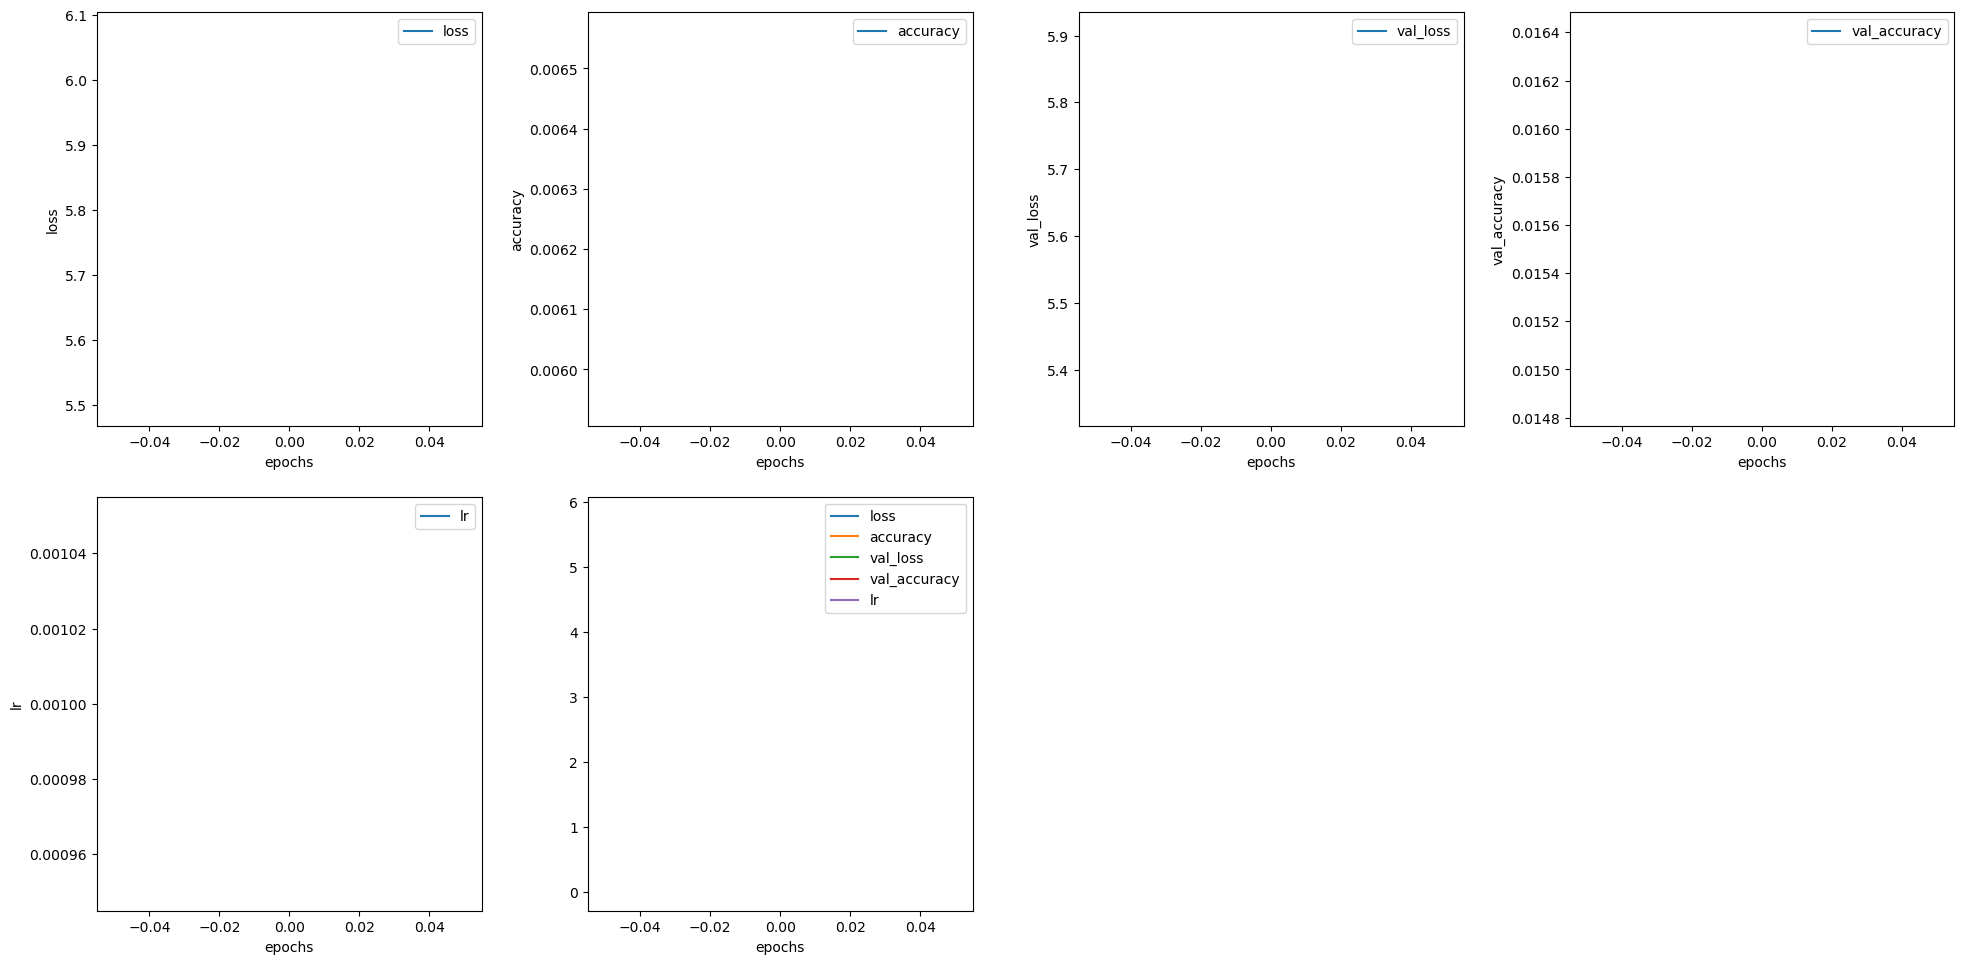

In [32]:
plot_history(history)

# Inference Model

In [33]:
class TFLiteModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.prep_inputs = FeatureGen()
        self.model = model
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def call(self, inputs):
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        x = tf.expand_dims(x, axis=0)
        outputs = self.model(x)[0, :]
        # Return a dictionary with the output tensor
        return {'outputs': outputs}

In [34]:
tflite_keras_model = TFLiteModel(model)

## TFlite model must perform inference with less than 100 milliseconds of latency per video on average

In [35]:
for i in range(2):
    %timeit demo_output = tflite_keras_model(load_relevant_data_subset(path_train_df.path[i]))["outputs"]

11.3 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.3 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
tflite_keras_model.predict(load_relevant_data_subset(path_train_df.path[i]))["outputs"].shape

1/1 [==============================] - 0s 192ms/step


(250,)

In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS,
]
# converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

In [38]:
# Save model
model_path = "model.tflite"
with open(model_path, "wb") as f:
    f.write(tflite_model)

## Model must use less than 40 MB of storage space

In [39]:
!ls -lh model.tflite

-rw-r--r-- 1 root root 23M Apr  1 13:45 model.tflite


In [40]:
!zip submission.zip $model_path

  adding: model.tflite (deflated 8%)


In [41]:
%pip install tflite_runtime --quiet

Note: you may need to restart the kernel to use updated packages.


In [42]:
import tflite_runtime.interpreter as tflite

# load you tflite model
interpreter = tflite.Interpreter("model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())

prediction_fn = interpreter.get_signature_runner("serving_default")

# predict class of the relevant video
output = prediction_fn(inputs=load_relevant_data_subset(path_train_df.path[0]))
sign = np.argmax(output["outputs"])

print("PREDICTION : ", decoder(sign))
print("ACTUAL   : ", path_train_df.sign[0])

PREDICTION :  dry
ACTUAL   :  blow


INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 52 nodes with 2 partitions.



In [43]:
"""
import tensorflow as tf
import numpy as np

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors information
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare your test input data (ensure it has the correct shape)
input_data = np.array(load_relevant_data_subset(path_train_df.path[0]), dtype=np.float32)

# Set the input tensor with your test data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the model
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data.shape)
print(output_data.argmax())
print(decoder(output_data.argmax()))
"""

"\nimport tensorflow as tf\nimport numpy as np\n\n# Load the TFLite model\ninterpreter = tf.lite.Interpreter(model_path='model.tflite')\ninterpreter.allocate_tensors()\n\n# Get input and output tensors information\ninput_details = interpreter.get_input_details()\noutput_details = interpreter.get_output_details()\n\n# Prepare your test input data (ensure it has the correct shape)\ninput_data = np.array(load_relevant_data_subset(path_train_df.path[0]), dtype=np.float32)\n\n# Set the input tensor with your test data\ninterpreter.set_tensor(input_details[0]['index'], input_data)\n\n# Run the model\ninterpreter.invoke()\n\n# Get the output tensor\noutput_data = interpreter.get_tensor(output_details[0]['index'])\nprint(output_data.shape)\nprint(output_data.argmax())\nprint(decoder(output_data.argmax()))\n"